In [3]:
from sudoku import predict_image

In [31]:
image = cv2.imread('train/train_5.jpg')

In [32]:
predict_image(image)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 [array([[1, 8, 7, 2, 5, 8, 8, 4, 9],
         [4, 5, 7, 7, 7, 9, 5, 3, 6],
         [8, 2, 5, 7, 6, 1, 3, 1, 2],
         [8, 9, 6, 9, 1, 8, 8, 2, 4],
         [6, 2, 8, 5, 7, 5, 8, 3, 8],
         [2, 4, 7, 2, 1, 4, 1, 3, 4],
         [4, 1, 5, 7, 1, 3, 8, 4, 3],
         [1, 1, 7, 9, 2, 8, 5, 5, 3],
         [2, 6, 3, 9, 1, 8, 7, 6, 2]], dtype=int16)])

# Libraries

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import joblib

%matplotlib inline

In [246]:
from skimage import io
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks, ProjectiveTransform, warp, resize
from skimage.measure import LineModelND, ransac, label
from scipy.ndimage.filters import convolve
from imutils.perspective import four_point_transform
import cv2

In [247]:
# two auxilary functions
def get_line(a, b, x_lim, y_lim=None):
    x = np.linspace(*x_lim)
    y = a * x + b
    if y_lim is not None:
        y = y[y>=y_lim[0]]
        y = y[y<=y_lim[1]]
    return x, y

def hough_thetaro_to_ab(theta, ro):
    a = -1 /np.tan(theta)
    b = ro / np.sin(theta)
    return a, b

In [248]:
import scipy
from scipy import stats

def get_gaussian_kernel(size=17, nsig=3):
    x = np.linspace(-nsig, nsig, size+1)
    kernel_1D = np.diff(stats.norm.cdf(x))
    
    kernel_2D = np.outer(kernel_1D, kernel_1D)
    kernel_2D_norm = kernel_2D / kernel_2D.sum()
    
    return kernel_2D_norm

In [249]:
def show(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [468]:
img = cv2.imread('train/train_4.jpg', 0)

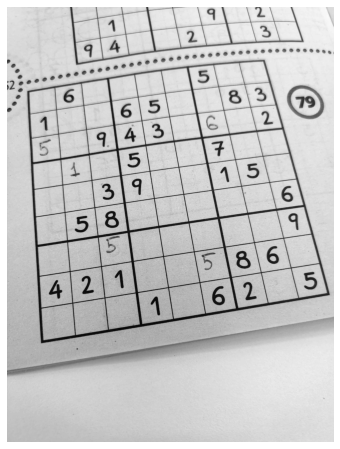

In [469]:
show(img)

# Mask

In [470]:
img = cv2.medianBlur(img,5)

In [471]:
th = cv2.adaptiveThreshold(img,np.max(img),cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,61,15)
#th = img < 100

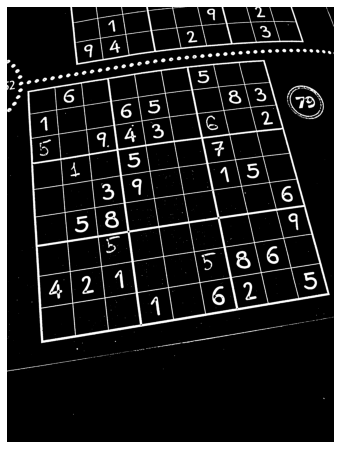

In [472]:
show(th)

In [473]:
contours, hierarchy = cv2.findContours(th.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [474]:
#we can compute area of each contour 
areas = (cv2.contourArea(cnt) for cnt in contours)
#then exclude the first one = the whole image
areas = filter(lambda x: x[0] != 0, enumerate(areas))
#and select the largest one
cnt_id, area = max(areas, key=lambda x: x[1])

In [475]:
#Second argument specify whether shape is a closed contour (if passed True)
perimeter = cv2.arcLength(contours[cnt_id], True) 

In [476]:
epsilon = 0.1 * perimeter
approx = cv2.approxPolyDP(contours[cnt_id], epsilon, True)

In [477]:
# approx = contours[cnt_id].reshape(-1,2)

In [478]:
# approx

In [479]:
# p0 = list(approx[np.argmin(approx[:,0])])
# p1 = list(approx[np.argmax(approx[:,0])])
# p2 = list(approx[np.argmin(approx[:,1])])
# p3 = list(approx[np.argmax(approx[:,1])])

In [480]:
# points = np.array([[p0],[p1],[p2],[p3]])

In [481]:
# points

In [482]:
mask = np.zeros_like(img)

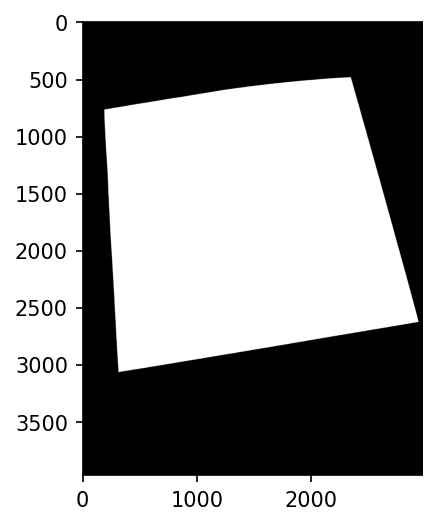

In [483]:
cv2.drawContours(mask, contours, cnt_id, (1,1,1), -1)

# for i in range(3):
    

plt.figure(dpi=150)
plt.imshow(mask, 'gray')

# Extracting digits

In [484]:
sudoku = four_point_transform(img, approx.reshape(-1,2))

In [485]:
padd = 10
sudoku = sudoku[padd:-padd, padd:-padd]

In [486]:
padd = 10
sudoku_0 = np.zeros(np.array(sudoku.shape)+2*padd)
sudoku_0[padd:-padd, padd:-padd] = sudoku

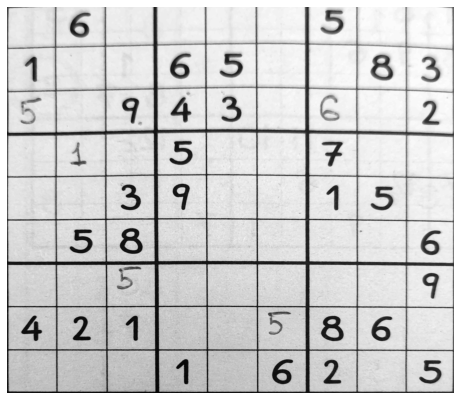

In [487]:
show(sudoku)

In [488]:
sudoku_bl = cv2.medianBlur(sudoku.astype('uint8'),5)

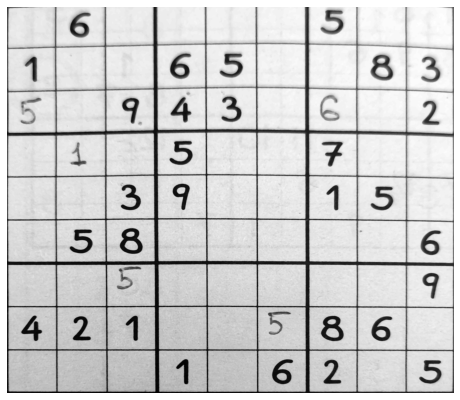

In [489]:
show(sudoku_bl)

In [490]:
[sudoku_table.astype(np.int16)]

[array([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1,  8,  9,  4, -1, -1, -1],
        [-1, -1, -1,  6, -1, -1, -1, -1, -1],
        [-1,  6,  5,  1, -1,  9,  7,  8, -1],
        [-1,  1, -1, -1, -1, -1, -1,  3, -1],
        [-1,  3,  9,  4, -1,  5,  6, -1, -1],
        [-1, -1, -1,  9, -1,  8, -1, -1, -1],
        [-1, -1, -1,  2,  1,  3, -1,  4, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int16)]

## New approach

In [491]:
height, width = np.array(sudoku_bl.shape) // 9

In [492]:
from skimage.measure import label

In [493]:
sorted_cells = []
for i in range(9):
    for j in range(9):
        digit = sudoku_bl[i*height:(i+1)*height, j*width:(j+1)*width][padd:-padd, padd:-padd]
#         mask = cv2.adaptiveThreshold(digit, np.max(digit),cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,13,5).astype(bool)
        mask_int = digit < 100
        mask = mask_int.copy()
        mask[np.mean(mask_int, axis=1) == 1] = 0
        mask[:, (np.mean(mask_int, axis=0) == 1)] = 0
        l = label(mask)
        if len(np.unique(l)) > 1:
            digit_label = np.argmax([np.sum(l==i) for i in np.unique(l) if i!=0])
            mask = mask * (l==digit_label+1)
        sorted_cells.append(resize(mask, (28,28)))
sorted_cells = np.array(sorted_cells).reshape(9,9,28,28)

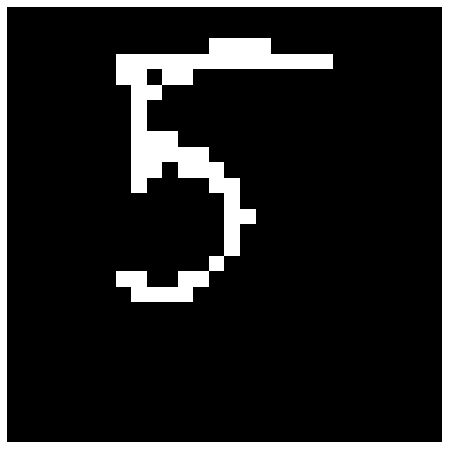

In [495]:
show(sorted_cells[7][5])

# Filling table

In [308]:
sudoku_table = np.zeros((9,9))

In [309]:
model = joblib.load('model.joblib')

In [310]:
for i in range(sorted_cells.shape[0]):
    for j in range(sorted_cells.shape[1]):
        if np.sum(sorted_cells[i][j]) < 30:
            sudoku_table[i][j] = -1
        else:
            sudoku_table[i][j] = model.predict(sorted_cells[i][j].reshape(1,-1))[0]

In [311]:
[sudoku_table.astype(np.int16)]

[array([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1,  8,  9,  4, -1, -1, -1],
        [-1, -1, -1,  6, -1, -1, -1, -1, -1],
        [-1,  6,  5,  1, -1,  9,  7,  8, -1],
        [-1,  1, -1, -1, -1, -1, -1,  3, -1],
        [-1,  3,  9,  4, -1,  5,  6, -1, -1],
        [-1, -1, -1,  9, -1,  8, -1, -1, -1],
        [-1, -1, -1,  2,  1,  3, -1,  4, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int16)]

# Model

In [91]:
from keras.datasets import mnist

In [377]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [378]:
#img_1
X_to_train = []
y_to_train = []
X_to_train.append(sorted_cells[0][2].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[0][4].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[1][3].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[1][5].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[1][6].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[0][7].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[0][8].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[2][4].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[2][5].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[2][6].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[2][8].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[3][5].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[3][8].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[4][0].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[4][5].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[4][6].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[4][8].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[5][0].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[5][3].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[5][5].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[5][6].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[6][2].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[6][3].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[6][4].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[6][6].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[6][7].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[7][0].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[7][1].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[7][3].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[8][1].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[8][3].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[8][5].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[8][6].reshape(1,-1))
y_to_train.append(5)

In [401]:
# img_2
X_to_train = []
y_to_train = []
X_to_train.append(sorted_cells[1][3].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[1][4].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[1][5].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[2][3].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[2][5].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[3][1].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[3][2].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[3][3].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[3][5].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[3][6].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[3][7].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[1][3].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[4][1].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[4][7].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[1][3].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[5][1].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[5][2].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[5][3].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[5][5].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[5][6].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[5][7].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[6][3].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[6][5].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[7][3].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[7][4].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[7][5].reshape(1,-1))
y_to_train.append(3)

In [424]:
# img_3
X_to_train = []
y_to_train = []
X_to_train.append(sorted_cells[0][0].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[0][1].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[0][4].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[0][5].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[1][1].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[1][3].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[1][7].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[2][0].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[2][4].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[2][5].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[2][7].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[3][4].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[3][6].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[3][7].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[4][0].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[4][2].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[4][7].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[4][8].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[5][1].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[5][4].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[5][5].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[5][6].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[5][7].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[6][0].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[6][2].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[6][6].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[6][8].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[7][2].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[7][6].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[8][3].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[8][7].reshape(1,-1))
y_to_train.append(6)

In [448]:
# img_4
X_to_train = []
y_to_train = []
X_to_train.append(sorted_cells[0][0].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[0][3].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[0][5].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[0][8].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[1][1].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[1][7].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[2][2].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[2][3].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[2][5].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[2][6].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[3][0].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[3][2].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[3][4].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[3][6].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[3][8].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[4][3].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[4][5].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[5][0].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[5][2].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[5][4].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[5][6].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[5][8].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[6][2].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[6][3].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[6][5].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[6][6].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[7][2].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[7][7].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[8][0].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[8][3].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[8][5].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[8][8].reshape(1,-1))
y_to_train.append(9)

In [497]:
# img_5
X_to_train = []
y_to_train = []
X_to_train.append(sorted_cells[0][1].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[0][6].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[1][0].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[1][3].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[1][4].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[1][7].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[1][8].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[2][0].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[2][2].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[2][3].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[2][4].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[2][6].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[2][8].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[3][1].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[3][3].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[3][6].reshape(1,-1))
y_to_train.append(7)
X_to_train.append(sorted_cells[4][2].reshape(1,-1))
y_to_train.append(3)
X_to_train.append(sorted_cells[4][3].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[4][6].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[4][7].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[5][1].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[5][2].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[5][8].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[6][2].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[6][8].reshape(1,-1))
y_to_train.append(9)
X_to_train.append(sorted_cells[7][0].reshape(1,-1))
y_to_train.append(4)
X_to_train.append(sorted_cells[7][1].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[7][2].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[7][5].reshape(1,-1))
y_to_train.append(5)
X_to_train.append(sorted_cells[7][6].reshape(1,-1))
y_to_train.append(8)
X_to_train.append(sorted_cells[7][7].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[8][3].reshape(1,-1))
y_to_train.append(1)
X_to_train.append(sorted_cells[8][5].reshape(1,-1))
y_to_train.append(6)
X_to_train.append(sorted_cells[8][6].reshape(1,-1))
y_to_train.append(2)
X_to_train.append(sorted_cells[8][5].reshape(1,-1))
y_to_train.append(5)

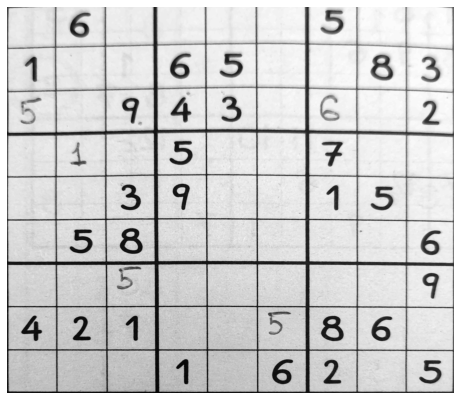

In [496]:
show(sudoku)

In [498]:
X_to_train = np.array(X_to_train).reshape(-1,784)
y_to_train = np.array(y_to_train)

In [275]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [380]:
X_train, X_test = (X_train/255).flatten().reshape(60000,-1), (X_test/255).flatten().reshape(10000,-1)

In [500]:
X_train = np.concatenate((X_train, X_to_train))
y_train = np.concatenate((y_train, y_to_train))

In [502]:
X_train.shape

(60157, 784)

In [503]:
svm = SVC(kernel='poly', C=0.001, gamma=10)

In [504]:
svm.fit(X_train, y_train)

SVC(C=0.001, gamma=10, kernel='poly')

In [505]:
joblib.dump(svm, 'model.joblib')

['model.joblib']

In [506]:
model.predict(sorted_cells[0][3].reshape(1,-1))[0]

4

In [135]:
svm.predict(sorted_cells[1][3].reshape(1,-1))[0]

8

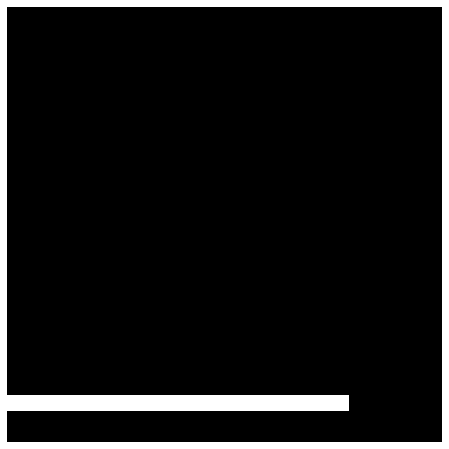

In [507]:
show(sorted_cells[0][3])